In [3]:
!pip install scikit-uplift

In [1]:
from pprint import pprint

from sklift.metrics import uplift_at_k, qini_auc_score

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
import torch
import torch.nn as nn

def indirect_loss_function(y_true, preds0, preds1, alpha, T, p, c=1e-7):

    # preds0 is prediction for data with 0 treatment and preds1 is predictions for data with 1 treatment
    denom1 = torch.maximum(preds0 + preds1, torch.ones(preds1.shape).to(device) * c)
    Pi1 = preds1 / denom1
    denom2 = torch.maximum((1 - preds0) + (1 - preds1), torch.ones(preds1.shape).to(device) * c)
    Pi0 = (1 - preds1) / denom2
    Pi = y_true * Pi1 + (1 - y_true) * Pi0
    I = nn.functional.binary_cross_entropy(Pi, T)

    preds = T * preds1 + (1 - T) * preds0
    L = nn.functional.binary_cross_entropy(preds, y_true)

    return alpha * L + (1 - alpha) * I

def direct_loss_function(y_true, preds0, preds1, alpha, T, p):
    #z = y_true * (T - p) / (p * (1 - p))
    e_X = (T == 1).sum() / len(T) 
    z = (T * y_true) / e_X + ((1 - T) * y_true) / (1 - e_X)
    vec = (z - preds1 + preds0)
    J = vec.matmul(vec) / len(vec)
    preds = T * preds1 + (1 - T) * preds0
    L = nn.functional.binary_cross_entropy(preds, y_true)
    return alpha * L + (1 - alpha) * J

In [3]:
from torch.utils.data import Dataset, DataLoader

class RealDataset(Dataset):

    def __init__(self, data, target=None, treatment=None):
        super(RealDataset, self).__init__()
        self.data = torch.from_numpy(data.values).type(torch.FloatTensor)
        if target is not None:
            self.target = torch.from_numpy(target.values).type(torch.FloatTensor)
        if treatment is not None:
            self.treatment = torch.from_numpy(treatment.values).type(torch.FloatTensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Make loader to give row with 0 treatment and row with 1 treatment for one query

        m0 = torch.zeros((1, self.data.shape[1] + 1))
        m0[:, :-1] = self.data[idx, :]
        m0[:, -1] = 0
        m1 = torch.zeros((1, self.data.shape[1] + 1))
        m1[:, :-1] = self.data[idx, :]
        m1[:, -1] = 1

        if self.target is None:
            return m0.squeeze().to(device), m1.squeeze().to(device)
        else:
            return (m0.squeeze().to(device), m1.squeeze().to(device), 
                    self.target[idx].to(device), self.treatment[idx].to(device))

# X5 Retail data

In [4]:
%matplotlib inline
df_clients = pd.read_csv('clients.csv', index_col='client_id')
df_train = pd.read_csv('uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('uplift_test.csv', index_col='client_id')


df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.to_datetime(df_features['first_issue_date']).min()) / pd.Timedelta('365d')

df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.to_datetime(df_features['first_redeem_date']).min()) / pd.Timedelta('365d')

df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']

df_features = df_features.join(pd.get_dummies(df_features['gender']))
df_features['first_redeem_time'] = df_features['first_redeem_time'].fillna(df_features['first_redeem_time'].mean())
df_features['issue_redeem_delay'] = df_features['issue_redeem_delay'].fillna(df_features['issue_redeem_delay'].mean())

df_features = df_features.drop(['first_issue_date', 'first_redeem_date', 'gender'], axis=1)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)


X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

In [5]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [6]:
batch_size = 50

train_dataset = RealDataset(X_train, y_train, treat_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = RealDataset(X_val, y_val, treat_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
input_dim = 8
hidden_dims = [20, 20, 30, 10]
dims = [input_dim] + hidden_dims + [1]

layers = []
for i in range(len(dims) - 1):
    layers.append(nn.Linear(dims[i], dims[i+1]))
    layers.append(nn.LeakyReLU())
layers[-1] = nn.Sigmoid()
model = nn.Sequential(*layers).to(device)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
N_EPOCHS = 100
alpha = 0.8
p = 0.5

train_losses = []
test_losses = []
test_upl_at_k = []
test_quini = []

for i in range(N_EPOCHS):

    loss_train = []

    for data0, data1, target, treat in train_loader:
        
        optimizer.zero_grad()
        preds0 = model(data0).squeeze()
        preds1 = model(data1).squeeze()
        loss = indirect_loss_function(target, preds0, preds1, alpha, treat, p)
        loss.backward()
        optimizer.step()
        
        loss_train.append(loss.item())
    loss_train = np.mean(loss_train)

    if i % 10 == 0 or i == N_EPOCHS - 1:
        with torch.no_grad():
            labels_val = []
            preds_val = []
            loss_val = []
            upl_at_k_scores = []
            quini_scores = []
            for data0, data1, target, treat in val_loader:
                labels_val += list(target)
                preds0 = model(data0).squeeze()
                preds1 = model(data1).squeeze()
                loss = indirect_loss_function(target, preds0, preds1, alpha, treat, p)
                preds_val += list(preds1 - preds0)
                loss_val.append(loss.item())

                score = uplift_at_k(target.cpu().numpy(), preds1 - preds0, treat.cpu().numpy(), strategy='by_group', k=0.3)
                upl_at_k_scores.append(score)
                score = qini_auc_score(target.cpu().numpy(), preds1 - preds0, treat.cpu().numpy())
                quini_scores.append(score)

            train_losses.append(loss_train)
            test_losses.append(np.mean(loss_val))
            test_upl_at_k.append(np.mean(upl_at_k_scores))
            test_quini.append(np.mean(quini_scores))

        print(f'Epoch {i} \t Loss train {loss_train:.6f} \t Loss test {np.mean(loss_val):.6f} \t Uplift at k test {np.mean(upl_at_k_scores):.6f} \t Quini AUC test {np.mean(quini_scores):.6f}')

Epoch 0 	 Loss train 0.669161 	 Loss test 0.668778 	 Uplift at k test 0.034172 	 Quini AUC test 0.004376
Epoch 10 	 Loss train 0.659441 	 Loss test 0.660955 	 Uplift at k test 0.045266 	 Quini AUC test 0.005313
Epoch 20 	 Loss train 0.656509 	 Loss test 0.655775 	 Uplift at k test 0.039694 	 Quini AUC test 0.007705
Epoch 30 	 Loss train 0.655402 	 Loss test 0.655229 	 Uplift at k test 0.039955 	 Quini AUC test 0.006445
Epoch 40 	 Loss train 0.655189 	 Loss test 0.656509 	 Uplift at k test 0.043516 	 Quini AUC test 0.008246
Epoch 50 	 Loss train 0.654596 	 Loss test 0.656391 	 Uplift at k test 0.045156 	 Quini AUC test 0.007553
Epoch 60 	 Loss train 0.654396 	 Loss test 0.655177 	 Uplift at k test 0.047011 	 Quini AUC test 0.011538
Epoch 70 	 Loss train 0.653965 	 Loss test 0.654941 	 Uplift at k test 0.044733 	 Quini AUC test 0.006785
Epoch 80 	 Loss train 0.653526 	 Loss test 0.654740 	 Uplift at k test 0.054619 	 Quini AUC test 0.013001
Epoch 90 	 Loss train 0.653283 	 Loss test 0.65

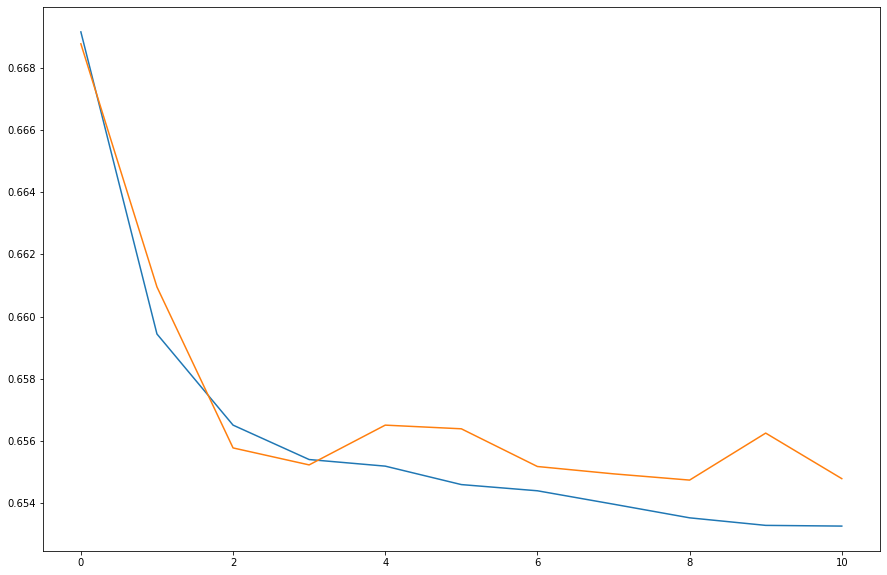

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(train_losses)
plt.plot(test_losses)

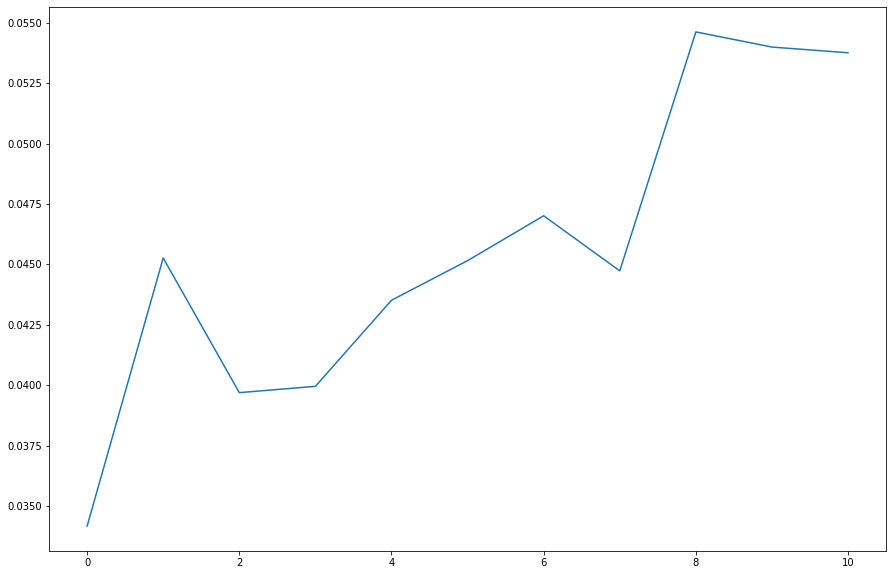

In [11]:
plt.figure(figsize=(15, 10))
plt.plot(test_upl_at_k)

# Hillstrom data

In [82]:
df = pd.read_csv('Hillstrom.csv')
df.drop(['history_segment', "conversion", "spend"], axis=1, inplace=True)

cat_cols = ['zip_code', 'channel']
df_ohe = pd.get_dummies(df, columns=cat_cols)
df_ohe.segment = df_ohe.segment.map({'Womens E-Mail': 1, 'Mens E-Mail': 1, 'No E-Mail': 0})

X = df_ohe.drop('visit', axis=1)
y = df_ohe['visit'].astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

treat_train = X_train['segment']
treat_test = X_test['segment']

X_train.drop(['segment'], axis=1, inplace=True)
X_test.drop(['segment'], axis=1, inplace=True)

In [83]:
len(X_train)

42880

In [84]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [85]:
batch_size = 50

train_dataset = RealDataset(X_train, y_train, treat_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = RealDataset(X_test, y_test, treat_test)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [86]:
input_dim = X_train.values.shape[1] + 1
hidden_dims = [20, 10, 10]
dims = [input_dim] + hidden_dims + [1]

layers = []
for i in range(len(dims) - 1):
    layers.append(nn.Linear(dims[i], dims[i+1]))
    layers.append(nn.LeakyReLU())
layers[-1] = nn.Sigmoid()
model = nn.Sequential(*layers).to(device)

In [87]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [88]:
N_EPOCHS = 150
alpha = 0.8
p = 0.5

train_losses = []
test_losses = []
test_upl_at_k = []
test_quini = []

for i in range(N_EPOCHS):

    loss_train = []

    for data0, data1, target, treat in train_loader:
        
        optimizer.zero_grad()
        preds0 = model(data0).squeeze()
        preds1 = model(data1).squeeze()
        loss = indirect_loss_function(target, preds0, preds1, alpha, treat, p)# + 0.01 * sum([(i ** 2).sum() for i in model.parameters()])
        loss.backward()
        optimizer.step()
        
        loss_train.append(loss.item())
    loss_train = np.mean(loss_train)

    if i % 10 == 0 or i == N_EPOCHS - 1:
        with torch.no_grad():
            labels_val = []
            preds_val = []
            treats_val = []
            loss_val = []

            for data0, data1, target, treat in val_loader:
                preds0 = model(data0).squeeze()
                preds1 = model(data1).squeeze()
                loss = indirect_loss_function(target, preds0, preds1, alpha, treat, p)# + 0.01 * sum([(i ** 2).sum() for i in model.parameters()])

                labels_val += list(target)
                preds_val += list(preds1 - preds0)
                treats_val += list(treat)
                loss_val.append(loss.item())

            upl_score = uplift_at_k(labels_val, preds_val, treats_val, strategy='by_group', k=0.3)
            test_upl_at_k.append(upl_score)
            quini_score = qini_auc_score(labels_val, preds_val, treats_val)
            test_quini.append(quini_score)

            train_losses.append(loss_train)
            test_losses.append(np.mean(loss_val))

        print(f'Epoch {i} \t Loss train {loss_train:.6f} \t Loss test {np.mean(loss_val):.6f} \t Uplift at k test {upl_score:.6f} \t Quini AUC test {quini_score:.6f}')

Epoch 0 	 Loss train 0.602541 	 Loss test 0.550173 	 Uplift at k test 0.069443 	 Quini AUC test 0.015601
Epoch 1 	 Loss train 0.503222 	 Loss test 0.482277 	 Uplift at k test 0.047182 	 Quini AUC test -0.014242
Epoch 2 	 Loss train 0.481973 	 Loss test 0.477218 	 Uplift at k test 0.044653 	 Quini AUC test -0.013844
Epoch 3 	 Loss train 0.479082 	 Loss test 0.474917 	 Uplift at k test 0.046104 	 Quini AUC test -0.014993
Epoch 4 	 Loss train 0.476627 	 Loss test 0.472705 	 Uplift at k test 0.040027 	 Quini AUC test -0.016881
Epoch 5 	 Loss train 0.474810 	 Loss test 0.472816 	 Uplift at k test 0.045861 	 Quini AUC test -0.014557
Epoch 6 	 Loss train 0.473297 	 Loss test 0.469488 	 Uplift at k test 0.041668 	 Quini AUC test -0.014431
Epoch 7 	 Loss train 0.471811 	 Loss test 0.468663 	 Uplift at k test 0.043181 	 Quini AUC test -0.016581
Epoch 8 	 Loss train 0.470662 	 Loss test 0.466975 	 Uplift at k test 0.044115 	 Quini AUC test -0.020683
Epoch 9 	 Loss train 0.469601 	 Loss test 0.466

# Kuusito data

In [68]:
df = pd.read_csv('Kuusito.csv')
df.drop(['customer_type'], axis=1, inplace=True)

df = df.replace(r'Value', '', regex=True)
df['target_control'] = df['target_control'].map({'control': 1, 'target': 0})
df['outcome'] = df['outcome'].map({'negative': 0, 'positive': 1})

df = pd.get_dummies(df,drop_first=True)

X = df.drop('outcome', axis=1).astype('int64')
y = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

treat_train = X_train['target_control']
treat_test = X_test['target_control']

X_train.drop(['target_control'], axis=1, inplace=True)
X_test.drop(['target_control'], axis=1, inplace=True)
X_train.drop(['customer_id'], axis=1, inplace=True)
X_test.drop(['customer_id'], axis=1, inplace=True)

In [69]:
len(X_train)

6700

In [70]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [71]:
batch_size = 50

train_dataset = RealDataset(X_train, y_train, treat_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = RealDataset(X_test, y_test, treat_test)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [72]:
input_dim = X_train.values.shape[1] + 1
hidden_dims = [20, 10]
dims = [input_dim] + hidden_dims + [1]

layers = []
for i in range(len(dims) - 1):
    layers.append(nn.Linear(dims[i], dims[i+1]))
    layers.append(nn.LeakyReLU())
layers[-1] = nn.Sigmoid()
model = nn.Sequential(*layers).to(device)

In [73]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [74]:
N_EPOCHS = 100
alpha = 0.8
p = 0.5

train_losses = []
test_losses = []
test_upl_at_k = []
test_quini = []

for i in range(N_EPOCHS):

    loss_train = []

    for data0, data1, target, treat in train_loader:
        
        optimizer.zero_grad()
        preds0 = model(data0).squeeze()
        preds1 = model(data1).squeeze()
        loss = indirect_loss_function(target, preds0, preds1, alpha, treat, p) + 0.01 * sum([(i ** 2).sum() for i in model.parameters()])
        loss.backward()
        optimizer.step()
        
        loss_train.append(loss.item())
    loss_train = np.mean(loss_train)

    if i % 10 == 0 or i == N_EPOCHS - 1:
        with torch.no_grad():
            labels_val = []
            preds_val = []
            loss_val = []
            upl_at_k_scores = []
            quini_scores = []
            for data0, data1, target, treat in val_loader:
                labels_val += list(target)
                preds0 = model(data0).squeeze()
                preds1 = model(data1).squeeze()
                loss = indirect_loss_function(target, preds0, preds1, alpha, treat, p) + 0.01 * sum([(i ** 2).sum() for i in model.parameters()])
                preds_val += list(preds1 - preds0)
                loss_val.append(loss.item())

                score = uplift_at_k(target.cpu().numpy(), preds1 - preds0, treat.cpu().numpy(), strategy='by_group', k=0.3)
                upl_at_k_scores.append(score)
                score = qini_auc_score(target.cpu().numpy(), preds1 - preds0, treat.cpu().numpy())
                quini_scores.append(score)

            train_losses.append(loss_train)
            test_losses.append(np.mean(loss_val))
            test_upl_at_k.append(np.mean(upl_at_k_scores))
            test_quini.append(np.mean(quini_scores))

        print(f'Epoch {i} \t Loss train {loss_train:.6f} \t Loss test {np.mean(loss_val):.6f} \t Uplift at k test {np.mean(upl_at_k_scores):.6f} \t Quini AUC test {np.mean(quini_scores):.6f}')

Epoch 0 	 Loss train 0.700026 	 Loss test 0.697960 	 Uplift at k test -0.019132 	 Quini AUC test -0.015107
Epoch 10 	 Loss train 0.678457 	 Loss test 0.691131 	 Uplift at k test 0.098858 	 Quini AUC test 0.054540
Epoch 30 	 Loss train 0.638988 	 Loss test 0.708529 	 Uplift at k test 0.170455 	 Quini AUC test 0.095124
Epoch 40 	 Loss train 0.626728 	 Loss test 0.717712 	 Uplift at k test 0.202880 	 Quini AUC test 0.106490
Epoch 50 	 Loss train 0.616477 	 Loss test 0.739045 	 Uplift at k test 0.192995 	 Quini AUC test 0.105062
Epoch 60 	 Loss train 0.610881 	 Loss test 0.738534 	 Uplift at k test 0.176353 	 Quini AUC test 0.100603
Epoch 70 	 Loss train 0.606990 	 Loss test 0.751618 	 Uplift at k test 0.191715 	 Quini AUC test 0.099734
Epoch 80 	 Loss train 0.600085 	 Loss test 0.755374 	 Uplift at k test 0.197397 	 Quini AUC test 0.105962
Epoch 90 	 Loss train 0.598750 	 Loss test 0.761357 	 Uplift at k test 0.188167 	 Quini AUC test 0.103648


# Synthetic data

In [ ]:
 !pip install causalml

In [60]:
from torch.utils.data import Dataset, DataLoader

class SynthDataset(Dataset):

    def __init__(self, data, target=None, treatment=None):
        super(SynthDataset, self).__init__()
        self.data = torch.from_numpy(data).type(torch.FloatTensor)
        if target is not None:
            self.target = torch.from_numpy(target).type(torch.FloatTensor)
        if treatment is not None:
            self.treatment = torch.from_numpy(treatment).type(torch.FloatTensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Make loader to give row with 0 treatment and row with 1 treatment for one query

        m0 = torch.zeros((1, self.data.shape[1] + 1))
        m0[:, :-1] = self.data[idx, :]
        m0[:, -1] = 0
        m1 = torch.zeros((1, self.data.shape[1] + 1))
        m1[:, :-1] = self.data[idx, :]
        m1[:, -1] = 1

        if self.target is None:
            return m0.squeeze().to(device), m1.squeeze().to(device)
        else:
            return (m0.squeeze().to(device), m1.squeeze().to(device), 
                    self.target[idx].to(device), self.treatment[idx].to(device))

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [61]:
from causalml.dataset import *
from sklearn.model_selection import train_test_split

y, X, treatment, tau, b, e = synthetic_data(mode=2, n=50000, p=8, sigma=1.0)
y = (y > np.median(y)).astype(int)
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(X, y, treatment, test_size=0.33, random_state=0)

batch_size = 50

train_dataset = SynthDataset(X_train, y_train, treat_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SynthDataset(X_test, y_test, treat_test)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [62]:
input_dim = X.shape[1] + 1
hidden_dims = [20, 20, 20, 10]
dims = [input_dim] + hidden_dims + [1]

layers = []
for i in range(len(dims) - 1):
    layers.append(nn.Linear(dims[i], dims[i+1]))
    layers.append(nn.LeakyReLU())
layers[-1] = nn.Sigmoid()
model = nn.Sequential(*layers).to(device)

In [63]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [64]:
N_EPOCHS = 50
alpha = 0.8
p = 0.5

train_losses = []
test_losses = []
test_upl_at_k = []
test_quini = []

for i in range(N_EPOCHS):

    loss_train = []

    for data0, data1, target, treat in train_loader:
        
        optimizer.zero_grad()
        preds0 = model(data0).squeeze()
        preds1 = model(data1).squeeze()
        loss = indirect_loss_function(target, preds0, preds1, alpha, treat, p) + 0.001 * sum([(i ** 2).sum() for i in model.parameters()])
        loss.backward()
        optimizer.step()
        
        loss_train.append(loss.item())
    loss_train = np.mean(loss_train)

    if i % 10 == 0 or i == N_EPOCHS - 1:
        with torch.no_grad():
            labels_val = []
            loss_val = []
            upl_at_k_scores = []
            quini_scores = []
            for data0, data1, target, treat in val_loader:
                labels_val += list(target)
                preds0 = model(data0).squeeze()
                preds1 = model(data1).squeeze()
                loss = indirect_loss_function(target, preds0, preds1, alpha, treat, p) + 0.001 * sum([(i ** 2).sum() for i in model.parameters()])
                loss_val.append(loss.item())

                score = uplift_at_k(target.cpu().numpy(), preds1 - preds0, treat.cpu().numpy(), strategy='by_group', k=0.3)
                upl_at_k_scores.append(score)
                score = qini_auc_score(target.cpu().numpy(), preds1 - preds0, treat.cpu().numpy())
                quini_scores.append(score)

            train_losses.append(loss_train)
            test_losses.append(np.mean(loss_val))
            test_upl_at_k.append(np.mean(upl_at_k_scores))
            test_quini.append(np.mean(quini_scores))

        print(f'Epoch {i} \t Loss train {loss_train:.6f} \t Loss test {np.mean(loss_val):.6f} \t Uplift at k test {np.mean(upl_at_k_scores):.6f} \t Quini AUC test {np.mean(quini_scores):.6f}')

Epoch 0 	 Loss train 0.577876 	 Loss test 0.518127 	 Uplift at k test 0.441825 	 Quini AUC test 0.177023
Epoch 10 	 Loss train 0.487359 	 Loss test 0.491602 	 Uplift at k test 0.477600 	 Quini AUC test 0.203868
Epoch 20 	 Loss train 0.485785 	 Loss test 0.491731 	 Uplift at k test 0.478680 	 Quini AUC test 0.206099
Epoch 30 	 Loss train 0.485274 	 Loss test 0.490078 	 Uplift at k test 0.472513 	 Quini AUC test 0.205923
Epoch 40 	 Loss train 0.484666 	 Loss test 0.489500 	 Uplift at k test 0.473318 	 Quini AUC test 0.206078
Epoch 50 	 Loss train 0.485336 	 Loss test 0.491046 	 Uplift at k test 0.479469 	 Quini AUC test 0.203581
Epoch 60 	 Loss train 0.485444 	 Loss test 0.489187 	 Uplift at k test 0.473421 	 Quini AUC test 0.205560
Epoch 70 	 Loss train 0.484534 	 Loss test 0.488873 	 Uplift at k test 0.469940 	 Quini AUC test 0.204711
Epoch 80 	 Loss train 0.484652 	 Loss test 0.489501 	 Uplift at k test 0.480417 	 Quini AUC test 0.205908
Epoch 90 	 Loss train 0.484793 	 Loss test 0.48

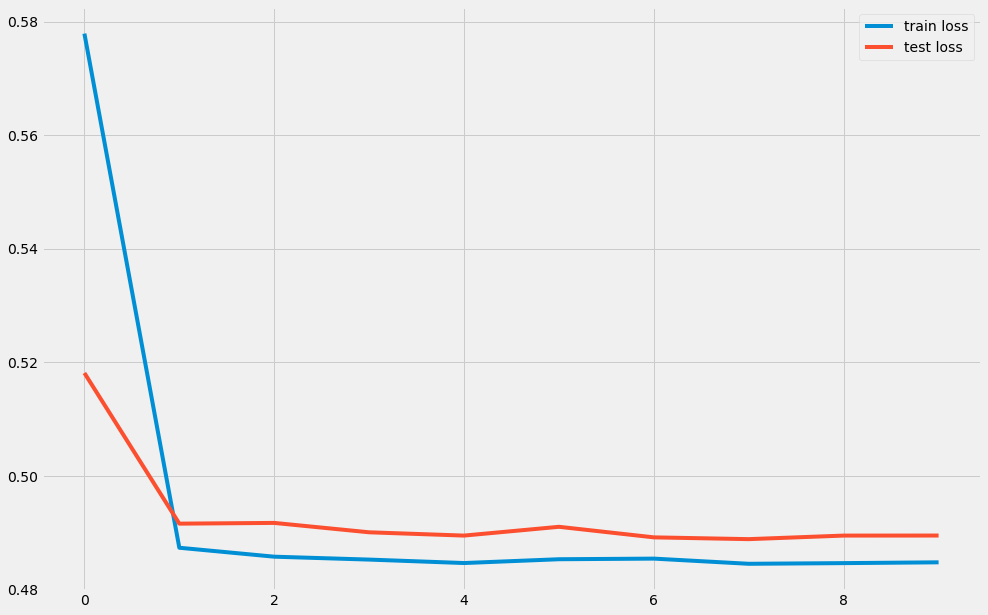

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()